# Data Preprocessing
Data preprocessing is always the first step in machine learning. It is a time consuming process. We will do following works:
 - Download the dataset
 - Visualize the data
 - Features and Labels generation
 - Label encoding
 - Feature normalization
 - Validation data generation
 - Save the data for easy access

## Downlaod noMNIST dataset
we will accomplish this work by following two dependancies:
 - urllib.request.urlretrieve: it downloads data based on the given URL.
 - os.path.isfile: this function is to check if file is already downloaded. We do not want to download the dataset again and again. 

In [10]:
from urllib.request import urlretrieve
import os

In [4]:
# Download the training and test dataset.
url_train = 'https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip'
file_train = 'notMNIST_train.zip'
url_test = 'https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip'
file_test = 'notMNIST_test.zip'

if not os.path.isfile(file_train):
    download(url_train, file_train)
if not os.path.isfile(file_test):
    download(url_test, file_test)

## Data Visualization
We will depends on following libraries to finish this step:
 - zipfile: it uncompresses the zip file. Our dataset is zip file, so we have to unzip it first.
 - pillow: [the friendly PIL fork](https://python-pillow.org/). PIL is the Python Imaging Library. We will process png files with this library.
 - matplotlib: this library will help us to show the image in the notebook.

In [4]:
%matplotlib inline
from zipfile import ZipFile
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np

In [5]:
with ZipFile('notMNIST_test.zip') as zipf:
    group1 = zipf.namelist()[1:11]
    group2 = zipf.namelist()[1001:1011]
    group3 = zipf.namelist()[-10:]
    print(zipf.namelist()[1:6])
    print(zipf.namelist()[1001:1006])
    print(zipf.namelist()[-5:])

['notMNIST_test/A0.png', 'notMNIST_test/A1.png', 'notMNIST_test/A10.png', 'notMNIST_test/A100.png', 'notMNIST_test/A101.png']
['notMNIST_test/B0.png', 'notMNIST_test/B1.png', 'notMNIST_test/B10.png', 'notMNIST_test/B100.png', 'notMNIST_test/B101.png']
['notMNIST_test/J995.png', 'notMNIST_test/J996.png', 'notMNIST_test/J997.png', 'notMNIST_test/J998.png', 'notMNIST_test/J999.png']


### Show one image
 - see a picture
 - see a pixel value of the image. To see the pixel value, we have to convert image into np.array. We will use this pixel value of image as a input feature later on.

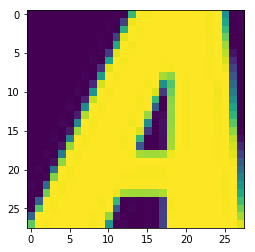

In [27]:
img = ZipFile('notMNIST_test.zip').open('notMNIST_test/A0.png')
img = Image.open(img) # cmap='binary' : this will show gray scale image
imshow(img)

In [31]:
#img.load()
np.array(img, dtype=np.float32)

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    2.,    0.,  171.,  255.,  252.,  255.,  255.,
         255.,  255.,  255.,  255.,  255.,  251.,  255.,  129.,    0.,
           3.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    2.,    0.,   50.,  249.,  255.,  254.,  255.,  255.,
         255.,  255.,  255.,  255.,  255.,  252.,  255.,  151.,    0.,
           2.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    2.,    0.,  160.,  255.,  252.,  255.,  255.,  255.,
         255.,  255.,  255.,  255.,  255.,  252.,  255.,  174.,    0.,
           2.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.,    0.,   48.,  245.,  255.,  254.,  255.,  255.,  255.,
         255.,  255.,  255.,  255.,  255.,  253.,  255.,  197.,    0.,
           1.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.

### Show group of images

In [8]:
images = []
for img in group1:
    image = ZipFile('notMNIST_test.zip').open(img)
    images.append(Image.open(image))
    
for img in group2:
    image = ZipFile('notMNIST_test.zip').open(img)
    images.append(Image.open(image))
    
for img in group3:
    image = ZipFile('notMNIST_test.zip').open(img)
    images.append(Image.open(image))
    
len(images)

30

In [11]:
labels = []
for file in group1:
    label = os.path.split(file)[1][0]
    labels.append(label)
    
for file in group2:
    label = os.path.split(file)[1][0]
    labels.append(label) 

for file in group3:
    label = os.path.split(file)[1][0]
    labels.append(label)
    
len(labels)

30

In [12]:
import matplotlib.pyplot as plt

Following function can be adapted in later.

In [13]:
def plot_images(images, labels, pred=None):
    assert len(images) == len(labels) == 30
    
    # Create figure with 3x10 sub-plots.
    fig, axes = plt.subplots(3, 10, figsize=(15,5))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i]) 

        # Show true and predicted classes.
        if pred is None:
            xlabel = "{0}".format(labels[i])
        else:
            xlabel = "{0} -> {1}".format(labels[i], pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

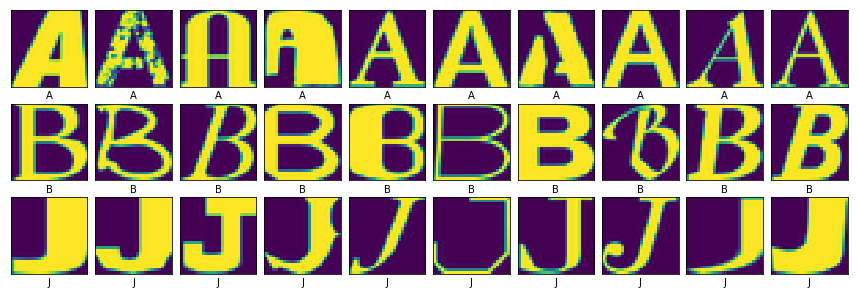

In [14]:
# Plot the images and labels using our helper-function above.
plot_images(images=images, labels=labels)

## Features and Labels data generation
Currently, our data are all images. We can not directly use them. In order to process our data into the model, we have to have features and labels. We will generate features and labels in this step.
 - [tqdm](https://pypi.python.org/pypi/tqdm): instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable). We have a huge data, so we want to see the progress.
 - Pillow Image will load the images as pixel value. And then we need to flatten it.

In [121]:
from tqdm import tqdm

In [124]:
def uncompress_features_labels(file):
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)


# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

  0%|                                                                                    | 0/210001 [00:00<?, ?files/s]<bound method tqdm.__del__ of  27%|██████████████████▉                                                    | 55988/210001 [01:21<03:45, 684.48files/s]>
Traceback (most recent call last):
  File "C:\Anaconda3\envs\tf1.0\lib\site-packages\tqdm\_tqdm.py", line 764, in __del__
    self.close()
  File "C:\Anaconda3\envs\tf1.0\lib\site-packages\tqdm\_tqdm.py", line 1002, in close
    self._decr_instances(self)
  File "C:\Anaconda3\envs\tf1.0\lib\site-packages\tqdm\_tqdm.py", line 407, in _decr_instances
  0%|                                                                        | 315/210001 [00:00<01:07, 3092.44files/s]
AttributeError: 'tqdm' object has no attribute 'pos'
100%|███████████████████████████████████████████████████████████████████████| 10001/10001 [00:01<00:00, 5751.54files/s]


In [129]:
train_features.shape

(210000, 784)

In [137]:
train_labels[:10]

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 
      dtype='<U1')

 - we have 210,000 images and labels. We do not want this much data. It requires too much computational power and time. So will just take 150,000 of them.
 - Obviously, we can not use labels shown above. We have to encode it first,

### Smaller size data

In [146]:
from sklearn.utils import resample

In [147]:
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

## Label encoding - one hot encoding

In [138]:
from sklearn.preprocessing import LabelBinarizer

In [148]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(test_labels)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

## Feature Normalization
Why do we need to do feature normalization? It is better to compare it and find it out.

In [ ]:
is_features_normal = False

In [ ]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    a = 0.1
    b = 0.9
    img_min = 0
    img_max = 255
    return a + (image_data - img_min)*(b-a)/ (img_max - img_min)

In [ ]:
if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True


## Split dateset into train and validation

In [140]:
from sklearn.model_selection import train_test_split

In [149]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

### SAVE the data for easy access

In [143]:
import pickle

In [151]:
pickle_file = 'notMNIST_noNorm.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST_noNorm.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.
